In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from os import listdir
from os.path import isfile, join
from sqlalchemy import create_engine

# First Read the data. 

In [2]:
def readData(filename):
    with open(filename) as f:
        data = pd.read_csv(f)
        
    return data

In [3]:
all_df = readData('indicators.csv')

In [4]:
def getSpecificDf(all_df, indicatorcode):
    specific_indicator = all_df[all_df.IndicatorCode == indicatorcode]
    years = list(range(min(all_df.Year), max(all_df.Year)+1))
    col_names = ['CountryCode', 'CountryName'] + years
    specific_indicator = specific_indicator[['CountryCode', 'CountryName', 'Year', 'Value']]
    for year in years:
        specific_indicator[year] = np.nan
    
    for index, row in specific_indicator.iterrows():
        row_value = deepcopy(row.Value)
        specific_indicator.loc[index, row.Year] = row_value

    specific_indicator = specific_indicator[col_names]
    specific_indicator_formatted = specific_indicator.groupby([specific_indicator.CountryCode, specific_indicator.CountryName]).sum()
    specific_indicator_formatted.reset_index(inplace=True)
    specific_indicator_formatted = specific_indicator_formatted.dropna(axis=1, how='all')
    
    years = specific_indicator_formatted.columns[2:]
    y_years = []
    for year in years:
        y_years.append('y'+str(year))
    adjusted_col_names = ['countrycode', 'countryname'] + y_years

    specific_indicator_formatted.columns = adjusted_col_names
    
    return specific_indicator_formatted

## Youth Unemployment

In [5]:
youth_unemployment = getSpecificDf(all_df, 'SL.TLF.ACTI.1524.ZS')

In [6]:
youth_unemployment.to_csv('youth_unemployment.csv', index=False)

## Food Production

In [7]:
gini_co = getSpecificDf(all_df, 'AG.PRD.FOOD.XD')

In [8]:
gini_co.to_csv('food_production_dom.csv', index=False)

## GDP PPP

In [9]:
gdp_ppp = getSpecificDf(all_df, 'NY.GDP.PCAP.PP.CD')

In [10]:
gdp_ppp.to_csv('gdp_ppp.csv', index=False)

## GDP Per Capita Growth

In [11]:
gdp_pcg = getSpecificDf(all_df, 'NY.GDP.PCAP.KD.ZG')

In [12]:
gdp_pcg.to_csv('gdp_pcg.csv', index=False)

## Growth in income, bottom 40%

In [13]:
income_40_growth = getSpecificDf(all_df, 'SI.SPR.PC40.ZG')

In [14]:
income_40_growth.to_csv('income_40_growth.csv', index=False)

## Food imports as a percentage

In [15]:
econ_food_imports = getSpecificDf(all_df, 'TM.VAL.FOOD.ZS.UN')

In [16]:
econ_food_imports.to_csv('econ_food_imports.csv', index=False)

## Total Labor force as a percentage:

In [17]:
total_labor_force = getSpecificDf(all_df, 'SL.TLF.ACTI.ZS')

In [18]:
total_labor_force.to_csv('total_labor_force.csv', index=False)

## Total Foreign Investment:

In [19]:
foreign_investment = getSpecificDf(all_df, 'BX.KLT.DINV.CD.WD')

In [20]:
foreign_investment.to_csv('foreign_investment.csv', index=False)

# Inflation of consumer products

In [21]:
inflation = getSpecificDf(all_df, 'FP.CPI.TOTL.ZG')

In [22]:
inflation.to_csv('inflation.csv', index=False)

# Pickling everything

In [23]:
import pickle

In [24]:
data1 = pd.read_csv('youth_unemployment.csv')
data2 = pd.read_csv('food_production_dom.csv')
data3 = pd.read_csv('gdp_ppp.csv')
data4 = pd.read_csv('gdp_pcg.csv')
data5 = pd.read_csv('income_40_growth.csv')
data6 = pd.read_csv('econ_food_imports.csv')
data7 = pd.read_csv('total_labor_force.csv')
data8 = pd.read_csv('foreign_investment.csv')
data9 = pd.read_csv('inflation.csv')

In [25]:
pickle.dump( data1, open( "youth_unemployment.pkl", "wb"))

In [26]:
pickle.dump( data2, open( "food_production_dom.pkl", "wb"))

In [27]:
pickle.dump( data3, open( "gdp_ppp.pkl", "wb"))

In [28]:
pickle.dump( data4, open( "gdp_pcg.pkl", "wb"))

In [29]:
pickle.dump( data5, open( "income_40_growth.pkl", "wb"))

In [30]:
pickle.dump( data6, open( "econ_food_imports.pkl", "wb"))

In [31]:
pickle.dump( data7, open( "total_labor_force.pkl", "wb"))

In [32]:
pickle.dump( data8, open( "foreign_investment.pkl", "wb"))

In [33]:
pickle.dump( data9, open( "inflation.pkl", "wb"))

# Now adding to SQL server. 

In [34]:
from sqlalchemy import create_engine
from os import listdir
from os.path import isfile, join

In [35]:
CONFIG = {}

In [36]:
with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value

In [37]:
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']

In [38]:
engine = create_engine(engine_path)

In [39]:
files = [f for f in listdir('thefiles/') if isfile(join('thefiles/', f))]

In [40]:
files

['econ_food_imports.csv',
 'food_production_dom.csv',
 'foreign_investment.csv',
 'gdp_pcg.csv',
 'gdp_ppp.csv',
 'gini_co.csv',
 'income_40_growth.csv',
 'inflation.csv',
 'total_labor_force.csv',
 'youth_unemployment.csv']

In [41]:
for file in files:
    file_with_path = 'thefiles/' + file
    raw_name = file[:-4]
    with open(file_with_path) as f:
        df = pd.read_csv(f)
    try:
        df.to_sql(raw_name, engine)
    except ValueError:
        pass

# Making queries of the data

In [42]:
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [43]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

In [44]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

In [45]:
table_names = [#'econ_food_imports',\
               #'gdp_growth',\
               'gdp_ppp',\
               #'gdp_pcg', \
               'food_production_dom',\
               'labor_force_participation',\
               'youth_unemployment',\
               'foreign_investment',\
               #'inflation', \
                'zscores']

In [46]:
x_cols = table_names[:-1]

In [47]:
years = [2009, 2010, 2011, 2012, 2013]

In [48]:
full_data = pd.DataFrame()

In [49]:
for year in years:
    query = makeSQLQuery(table_names, year)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['countrycode', 'year'])
    full_data = pd.concat([full_data, year_data])
    


In [50]:
full_data

,,gdp_ppp,food_production_dom,labor_force_participation,youth_unemployment,foreign_investment,zscores
countrycode,year,,,,,,
AFG,2009,1525.517054,116.510000,48.000000,37.599998,1.975127e+08,7.552656851
AGO,2009,NaN,164.910000,69.400002,52.599998,2.205298e+09,0.22745292
ALB,2009,9345.097500,112.110000,55.200001,33.900002,1.343091e+09,0.116318468
ARB,2009,13728.155608,110.015612,49.311070,32.852058,7.952285e+10,0.368862395
ARE,2009,59100.380538,100.490000,77.500000,53.599998,4.002700e+09,-0.275831441
ARM,2009,6158.301452,119.640000,59.200001,33.599998,7.600407e+08,0.168125894
AUS,2009,40205.026652,104.900000,65.599998,69.300003,2.868327e+10,-0.279701882
AUT,2009,40633.384215,104.030000,60.799999,60.599998,1.429321e+10,-0.279690998
AZE,2009,14900.508664,122.630000,64.800003,35.200001,2.900030e+09,-0.140058553


In [51]:
# pickle this 

In [52]:
pickle.dump( full_data, open( "bryan_data.pkl", "wb"))

In [53]:
full_data['zscores'] = full_data['zscores'].astype(float)

full_data.loc[full_data['zscores'] > 0, 'zscores'] = 1
full_data.loc[full_data['zscores'] <= 0, 'zscores'] = 0

try:
    full_data.loc[full_data['freedom_status'] == 'F', 'freedom_status'] = -1
    full_data.loc[full_data['freedom_status'] == 'PF', 'freedom_status'] = 0
    full_data.loc[full_data['freedom_status'] == 'NF', 'freedom_status'] = 1
except:
    pass


In [54]:
full_data[full_data.isnull().any(axis=1)]

,,gdp_ppp,food_production_dom,labor_force_participation,youth_unemployment,foreign_investment,zscores
countrycode,year,,,,,,
AGO,2009,NaN,164.91,69.400002,52.599998,2.205298e+09,1
LUX,2009,80331.758338,103.47,57.400002,32.299999,2.731333e+10,NaN
VUT,2009,2874.878880,104.12,71.000000,58.000000,3.214085e+07,NaN
WSM,2009,5243.269337,106.30,44.200001,30.299999,9.868117e+06,NaN
AGO,2010,NaN,173.96,69.699997,52.799999,-3.227211e+09,1
LUX,2010,84531.419254,92.50,57.000000,25.100000,3.858751e+10,NaN
LBY,2011,11023.437140,110.26,53.299999,37.099998,NaN,0
LUX,2011,91073.322083,92.54,56.799999,24.900000,9.748432e+09,NaN
AGO,2012,NaN,158.49,69.900002,52.799999,-6.897955e+09,0


In [55]:
full_data = full_data.dropna()

In [56]:
full_data

,,gdp_ppp,food_production_dom,labor_force_participation,youth_unemployment,foreign_investment,zscores
countrycode,year,,,,,,
AFG,2009,1525.517054,116.510000,48.000000,37.599998,1.975127e+08,1
ALB,2009,9345.097500,112.110000,55.200001,33.900002,1.343091e+09,1
ARB,2009,13728.155608,110.015612,49.311070,32.852058,7.952285e+10,1
ARE,2009,59100.380538,100.490000,77.500000,53.599998,4.002700e+09,0
ARM,2009,6158.301452,119.640000,59.200001,33.599998,7.600407e+08,1
AUS,2009,40205.026652,104.900000,65.599998,69.300003,2.868327e+10,0
AUT,2009,40633.384215,104.030000,60.799999,60.599998,1.429321e+10,0
AZE,2009,14900.508664,122.630000,64.800003,35.200001,2.900030e+09,0
BDI,2009,683.468685,112.460000,82.199997,65.300003,3.484045e+05,1


In [57]:
#for col in x_cols:
   #full_data[col] = (full_data[col] - full_data[col].mean())/full_data[col].std(ddof=0)


In [58]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True,
                   get_prediction=False
                  ):
    y_test_index=y_test.index
    
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    roc_auc_value = roc_auc_score(y_test,y_pred)
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: ()'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value, \
                                                                       roc_auc_value))
    elif get_prediction:
        y_pred=pd.Series(y_pred, index=y_test_index)
        return y_pred
        
    else:
        return accuracy_score_value, \
               precision_score_value, \
               recall_score_value, \
               f1_score_value, \
               roc_auc_value, \
               feature_importances

In [59]:
X = full_data[x_cols]
y = full_data['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [60]:
model = RandomForestClassifier()

In [61]:
y_pred = getScoreValues(X_train, X_test, y_train, y_test, RandomForestClassifier(n_estimators=30),verbose=False, get_features=False, get_prediction=True)

In [62]:
full_y_pred=pd.Series(y_pred, index=y_test.index)

In [63]:
full_y_pred.to_csv('bryan_2013_prediction.csv')

# Decision Tree

In [64]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.9084967320261438
Precision: 0.7647058823529411
Recall: 0.7090909090909091
f1: 0.7358490566037736
ROC AUC: ()


# Bernoulli

In [65]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.8202614379084967
Precision: 0.0
Recall: 0.0
f1: 0.0
ROC AUC: ()


/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Gaussian

In [66]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.3300653594771242
Precision: 0.20238095238095238
Recall: 0.9272727272727272
f1: 0.33224755700325737
ROC AUC: ()


# SVC (broken?)

In [67]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.8202614379084967
Precision: 0.0
Recall: 0.0
f1: 0.0
ROC AUC: ()


/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Random Forest

In [68]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9248366013071896
Precision: 0.9
Recall: 0.6545454545454545
f1: 0.7578947368421052
ROC AUC: ()


# ROC curve time

In [69]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.828649040202825


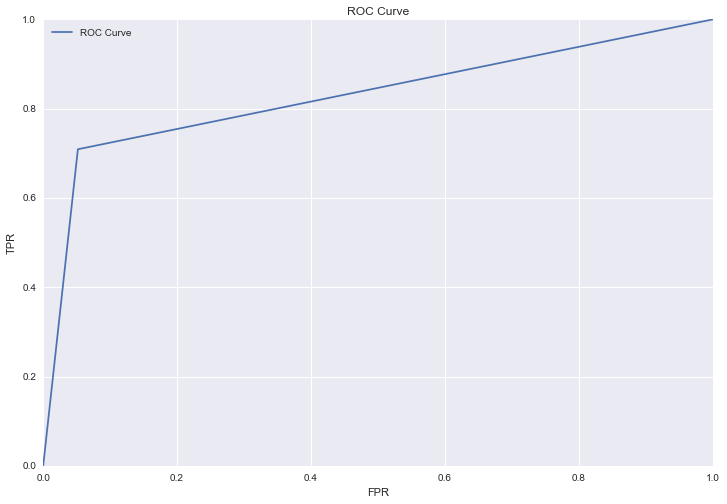

In [70]:
getROCcurve(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

AUC: 0.9503802969938429


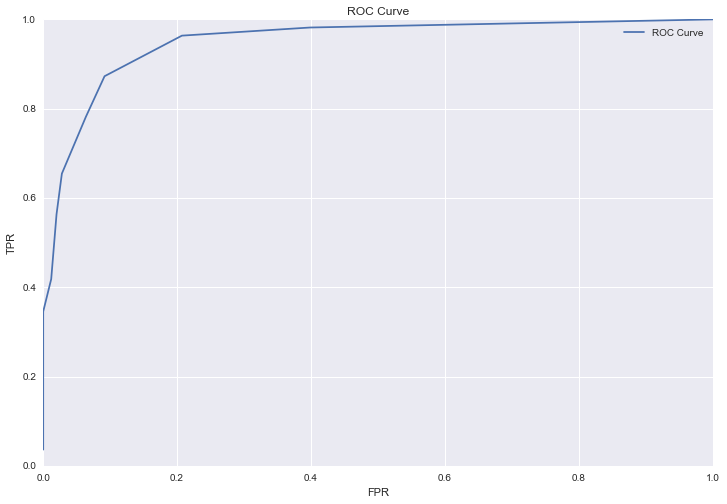

In [71]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

In [72]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=5)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [73]:
getScoreValuesByCV(X,y)

Accuracy: 0.8245641772268202
Precision: 0.45406698564593295
Recall: 0.13654188948306595
f1: 0.20233866163785302
ROC AUC: 0.6090760822576522


In [74]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

Accuracy: 0.9313615707006099
Precision: 0.9036706349206348
Recall: 0.6718360071301247
f1: 0.7912154996758359
ROC AUC: 0.9628302051658453


In [75]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.3137075149656162
Precision: 0.18252516439413363
Recall: 0.9105169340463458
f1: 0.30408551903692527
ROC AUC: 0.4968168297434369


In [76]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.915689360689608
Precision: 0.7226190476190475
Recall: 0.7493761140819964
f1: 0.7465961557559594
ROC AUC: 0.8394764987334649


In [77]:
getScoreValuesByCV(X,y, model=SVC())

/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bryanbumg

Accuracy: 0.8353005727101606
Precision: 0.0
Recall: 0.0
f1: 0.0
ROC AUC: 0.5


/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
X = full_data[x_cols]
y = full_data['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [79]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.predict(X_test)


array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [80]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])
X_train = X_train.reset_index(drop=True).as_matrix()
y_train = y_train.reset_index(drop=True).as_matrix()

smote = SMOTE(ratio=ratio, verbose=verbose)
smox, smoy = smote.fit_transform(X_train, y_train)

In [83]:
X_train = pd.DataFrame(smox, columns=x_cols)
y_train = pd.Series(smoy)

In [84]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.8921568627450981
Precision: 0.6527777777777778
Recall: 0.8545454545454545
f1: 0.7401574803149606
ROC AUC: ()


# Attempting oversampling 

In [85]:
def oversample_data(X_t, y_t, ratio):
    x_columns = X_t.columns
    
    X_t = X_t.reset_index(drop=True).as_matrix()
    y_t = y_t.reset_index(drop=True).as_matrix()

    smote = OverSampler(ratio=ratio, verbose=False)
    smox, smoy = smote.fit_transform(X_t, y_t)
    X_t = pd.DataFrame(smox, columns=x_columns)
    y_t = pd.Series(smoy)
    return X_t, y_t


In [86]:
X = full_data[x_cols]
y = full_data['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [87]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])

X_train, y_train = oversample_data(X_train, y_train, ratio)

In [88]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.6111111111111112
Precision: 0.20909090909090908
Recall: 0.41818181818181815
f1: 0.27878787878787875
ROC AUC: ()


In [89]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9281045751633987
Precision: 0.8235294117647058
Recall: 0.7636363636363637
f1: 0.7924528301886793
ROC AUC: ()


In [90]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.19934640522875818
Precision: 0.18120805369127516
Recall: 0.9818181818181818
f1: 0.3059490084985836
ROC AUC: ()


In [91]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.30392156862745096
Precision: 0.20075757575757575
Recall: 0.9636363636363636
f1: 0.3322884012539185
ROC AUC: ()


In [92]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.8954248366013072
Precision: 0.6949152542372882
Recall: 0.7454545454545455
f1: 0.7192982456140351
ROC AUC: ()


In [93]:
getScoreValues(X_train, X_test, y_train, y_test, model=LogisticRegression())

Accuracy: 0.8006535947712419
Precision: 0.125
Recall: 0.01818181818181818
f1: 0.031746031746031744
ROC AUC: ()


In [94]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [95]:
def getpickle(filename):

    try:
        with open(filename, 'rb') as picklefile:
            return pickle.load(picklefile)
    except:
        return 'There was an error trying to read this file.  Please check the filename or path.'

In [96]:
colors = getpickle('tableaucolors.pkl')

In [97]:
class getCrossValScoresBySSS(object):
    
    def __init__(self, 
                 local_X, 
                 local_y,
                 test_size=0.3,
                 n_iter=50
                ):
        self.model_list = [\
                          KNeighborsClassifier(n_neighbors=2), \
                          SVC(gamma=1, C=10, kernel='rbf'), \
                          SVC(),\
                          LogisticRegression(), \
                          BernoulliNB(), \
                          GaussianNB(), \
                          RandomForestClassifier(n_estimators=30), \
                          DecisionTreeClassifier() \
                          ]
        
        self.index_func = [\
                          'KNeighborsClassifier(n_neighbors=2)', \
                          'SVC(gamma=1, C=10, kernel=\'rbf\')', \
                          'SVC()',\
                          'LogisticRegression()', \
                          'BernoulliNB()', \
                          'GaussianNB()', \
                          'RandomForestClassifier(n_estimators=30)', \
                          'DecisionTreeClassifier()' \
                          ]
        
        self.initialize_scores()
        self.score_dict = {}
        self.colors =  getpickle('tableaucolors.pkl')
        self.X = local_X
        self.y = local_y
        self.x_cols = list(local_X.columns)
        self.ratio = float(local_y.value_counts()[0]) / (float(local_y.value_counts()[1]))
        self.sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    def initialize_scores(self):
        self.acc_array = []
        self.prec_array = []
        self.recall_array = []
        self.f1_array = []
        self.roc_auc_array = []
        self.feature_imp_array = []
        
    def get_cm_pred(self, model, X_t, y_t, X_ts):
        temp_model = model
        temp_model.fit(X_t, y_t)
        y_pd = temp_model.predict(X_ts)
        return y_pd
    
    def test_conversion_for_year(self, year, y_delta):
        #try:
            new_year = year+y_delta
            X_columns = self.X.columns
            X_te = self.X.loc[year, :]
            y_te = self.y.loc[new_year, :]
            y_te = y_te.reset_index('countrycode').reset_index(drop=True).set_index('countrycode')
            full = pd.concat([X_te, y_te], axis=1)
            full = full.dropna()
            X_te = full[X_columns]
            y_te = full['zscores']
            return X_te, y_te

        #except:
         #   print('Bad Year')
    
    def set_score_arrays(self, oversample, year, year_delta, model, get_features):
        for train_index, test_index in self.sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]
            
            #remove data of test year and all years after from train set
            if year != None: 
                X_train = X_train.loc[X_train.index.get_level_values('year') < year+year_delta]
                y_train = y_train.loc[y_train.index.get_level_values('year') < year+year_delta]
                X_test, y_test = self.test_conversion_for_year(year=year, y_delta=year_delta)

            if oversample:
                X_train, y_train = oversample_data(X_train, y_train, self.ratio)

            accuracy_score_value, precision_score_value, \
            recall_score_value, f1_score_value, roc_auc_value, \
            feature_importances = getScoreValues(X_train,
                                                 X_test,
                                                 y_train,
                                                 y_test,
                                                 model=model,
                                                 verbose=False,
                                                 get_features=get_features)

            self.acc_array.append(accuracy_score_value)
            self.prec_array.append(precision_score_value)
            self.recall_array.append(recall_score_value)
            self.f1_array.append(f1_score_value)
            self.roc_auc_array.append(roc_auc_value)
            self.feature_imp_array.append(feature_importances)
            
    def multi_plot_multi_model_metrics(self):
        index = list(range(len(self.model_list)))
        bw = 0.35
        score_list = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROCAUC']
        
        plt.figure(figsize=(18,5))
        
        for j, scoring in enumerate(score_list):
            ax = plt.subplot(151 + j)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            sns.set_style("whitegrid")

            plt.bar(index, self.score_dict[scoring], bw, 
                    align = 'center', 
                    #color = colors[(i*2)], 
                    alpha = 0.6, 
                    label = self.index_func)

            plt.title(scoring, fontsize=15, fontweight='bold')
            plt.xticks(index, self.index_func, rotation='vertical')
            plt.ylim(0.0, 1.1)
            if j == 0:
                plt.ylabel('Score',fontsize=20, fontweight='bold')
            #if j == 4:
            #    plt.legend()
            plt.grid(False)
            
    def single_plot_multi_model_metrics(self):
        default_index = list(range(len(self.model_list)))
        bw = 0.15
        score_list = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROCAUC']
        
        plt.figure(figsize=(18,5))
        
        for j,scoring in enumerate(score_list):
            ax = plt.subplot(111)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            sns.set_style("whitegrid")
            
            index = [i+bw*j for i in default_index]
            plt.bar(index, self.score_dict[scoring], bw, 
                    align = 'center', 
                    color = self.colors[(3+j)], 
                    alpha = 0.6, 
                    label = scoring)

            plt.title('Scores for Different Models', fontsize=15, fontweight='bold')
            tick_location = [i for i in default_index]
            plt.xticks(tick_location, self.index_func, rotation=60)
            plt.ylim(0.0, 1.1)
            if j == 0:
                plt.ylabel('Score',fontsize=20, fontweight='bold')
            if j == 4:
                plt.legend(loc='best')
            plt.grid(False)

    def get_multi_models(self,
                         oversample=True,
                         year=None,
                         year_delta=0,
                         make_single_plot=False,
                         make_multi_plots=False
                        ):
        self.score_dict = {}
        models_acc = []
        models_prec = []
        models_rec = []
        models_f1 = []
        models_roc_auc = []
        
        col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROCAUC']
        
        for a_model in self.model_list:
            self.initialize_scores()
            
            self.set_score_arrays(oversample=oversample,
                                  year=year,
                                  year_delta=year_delta,
                                  model=a_model,
                                  get_features=False)
                
            mean_acc = np.mean(self.acc_array)
            mean_prec = np.mean(self.prec_array)
            mean_recall = np.mean(self.recall_array)
            mean_f1 = np.mean(self.f1_array)
            mean_roc_auc = np.mean(self.roc_auc_array)
            
            models_acc.append(mean_acc)
            models_prec.append(mean_prec)
            models_rec.append(mean_recall)
            models_f1.append(mean_f1)
            models_roc_auc.append(mean_roc_auc)
            
        self.score_dict['Accuracy'] = models_acc
        self.score_dict['Precision'] = models_prec
        self.score_dict['Recall'] = models_rec
        self.score_dict['F1'] = models_f1
        self.score_dict['ROCAUC'] = models_roc_auc
        
        if make_multi_plots:
            self.plot_multi_model_metrics()
        elif make_single_plot:
            self.single_plot_multi_model_metrics()
        
        df = pd.DataFrame(self.score_dict, columns=col_names, index=self.index_func)
        return df
    
    def get_single_model(self,
                         model=KNeighborsClassifier(n_neighbors=2),
                         oversample=True,
                         year=None,
                         year_delta=0,
                         get_features=True,
                         get_cm=False,
                         verbose=True
                        ):
        
        self.initialize_scores()
        
        self.set_score_arrays(oversample=oversample,
                              year=year,
                              year_delta=year_delta,
                              model=model,
                              get_features=get_features) 
            
        if get_cm:
            # For getting a confusion matrix of the last model in the cross validated set
            y_pred = self.get_cm_pred(model, X_train, y_train, X_test)
            cm = confusion_matrix(y_test, y_pred)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(self.acc_array)
        mean_prec = np.mean(self.prec_array)
        mean_recall = np.mean(self.recall_array)
        mean_f1 = np.mean(self.f1_array)
        mean_roc_auc = np.mean(self.roc_auc_array)
        try:
            mean_feature_imp = np.mean(self.feature_imp_array, axis=0)
        except TypeError:
            mean_feature_imp = None
               
        if verbose:
            print('Avg Feature Importance: {}'.format(mean_feature_imp))
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(mean_acc, \
                                                                                        mean_prec, \
                                                                                        mean_recall,\
                                                                                        mean_f1, \
                                                                                        mean_roc_auc))

        else:
            return mean_acc, mean_prec, mean_recall, mean_f1, mean_roc_auc
        
    def future_crisis_countries(self,
                                model=KNeighborsClassifier(n_neighbors=2),
                                oversample=True,
                                year=None,
                                year_delta=0):
        assert year != None
        
        for train_index, test_index in self.sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]
            
            #remove data of test year from train set
            X_train = X_train.loc[X_train.index.get_level_values('year') != year+year_delta]
            y_train = y_train.loc[y_train.index.get_level_values('year') != year+year_delta]
            
            #Year prior is used later as the comparison between the desired year and its year prior
            _,year_prior = self.test_conversion_for_year(year=year, y_delta=(year_delta-1))
            X_test, y_test = self.test_conversion_for_year(year=year, y_delta=year_delta)
            
            if oversample:
                X_train, y_train = oversample_data(X_train, y_train, self.ratio)
            
            prediction = getScoreValues(X_train, 
                                       X_test, 
                                       y_train, 
                                       y_test, 
                                       model=model, 
                                       verbose=False, 
                                       get_features=False,
                                       get_prediction=True
                                      )
            prediction_actual = deepcopy(y_test)
            prediction_actual.name = 'prediction_actual'
            year_prior.name='year_prior'
            prediction.name='prediction'
            compare_df = pd.concat([year_prior, prediction, prediction_actual], axis=1)
            compare_df = compare_df.dropna()
            compare_df['net'] = compare_df.year_prior.subtract(compare_df.prediction)
            future_crisis = compare_df[compare_df.net < 0]
            future_crisis = future_crisis[future_crisis.prediction_actual == 1]
            print(future_crisis)
            
    def SVC_grid_search(self, oversample=True, year=None, year_delta=0):
        # This will perform cross val on one train/test from the SSS
        i = 0
        for tr_i, te_i in self.sss:
            if i == 0:
                train_index = tr_i
                test_index = te_i
            i += 1
        
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train, y_test = y.ix[train_index], y.ix[test_index]

        #remove data of test year and all years after from train set
        if year != None: 
            X_train = X_train.loc[X_train.index.get_level_values('year') < year+year_delta]
            y_train = y_train.loc[y_train.index.get_level_values('year') < year+year_delta]
            X_test, y_test = self.test_conversion_for_year(year=year, y_delta=year_delta)

        if oversample:
            X_train, y_train = oversample_data(X_train, y_train, self.ratio)
        
        # Set the parameters by cross-validation
        tuned_parameters = [{'kernel': ['rbf'],
                             'gamma': [1,1e-1,1e-2,1e-3, 1e-4],
                             'C': [1, 10, 100, 1000]
                            },
                            {'kernel': ['linear'],
                             'C': [1, 10, 100, 1000]
                            },
                            {'kernel':['poly'],
                             'degree':[1,2,3]
                            }]

        scores = ['accuracy', 'precision', 'recall', 'f1']

        for score in scores:
            print("# Tuning hyper-parameters for %s" % score)
            print()

            clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score, n_jobs=-1)
            clf.fit(X_train, y_train)

            print("Best parameters set found on development set:")
            print()
            print(clf.best_estimator_)
            print()
            print("Grid scores on development set:")
            print()
            for params, mean_score, scores in clf.grid_scores_:
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean_score, scores.std() / 2, params))
            print()

            print("Detailed classification report:")
            print()
            print("The model is trained on the full development set.")
            print("The scores are computed on the full evaluation set.")
            print()
            y_true, y_pred = y_test, clf.predict(X_test)
            print(classification_report(y_true, y_pred))
            print()
    
    

In [98]:
X = full_data[x_cols]
y = full_data['zscores']

# All glory to the Ken 

In [99]:
pol_modeling = getCrossValScoresBySSS(X,y)

/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.752418,0.234205,0.2272,0.229571,0.541100
"SVC(gamma=1, C=10, kernel='rbf')",0.836601,0.000000,0.0000,0.000000,0.500000
SVC(),0.836601,0.000000,0.0000,0.000000,0.500000
LogisticRegression(),0.809608,0.157278,0.0388,0.061593,0.499478
BernoulliNB(),0.399673,0.126255,0.6344,0.191476,0.494114
GaussianNB(),0.293987,0.181909,0.9496,0.305307,0.557769
RandomForestClassifier(n_estimators=30),0.934248,0.821469,0.7684,0.791758,0.867520
DecisionTreeClassifier(),0.902745,0.708014,0.6992,0.701189,0.820850


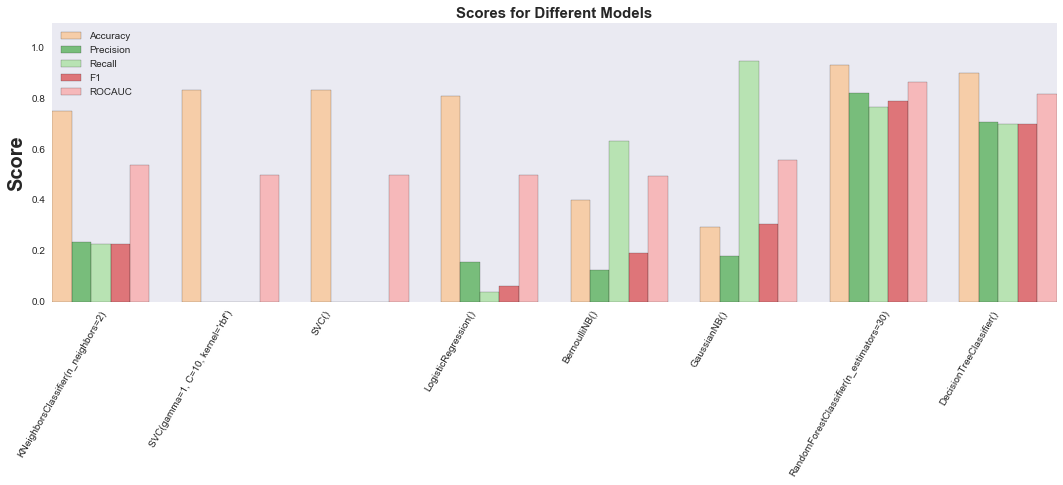

In [100]:
pol_modeling.get_multi_models(make_single_plot=True)

Avg Feature Importance: [ 0.32060735  0.12791415  0.20849882  0.16848983  0.17448986]
Accuracy: 0.9368627450980394
Precision: 0.8282803650627137
Recall: 0.78
f1: 0.8014879595004879
ROC AUC: 0.8737499999999998


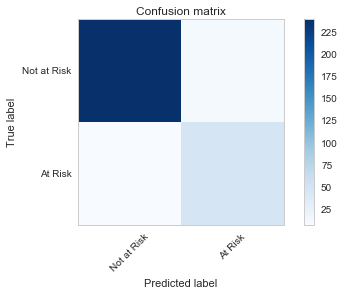

In [101]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=100), get_cm = True)

Avg Feature Importance: [ 0.32543099  0.12705567  0.20506557  0.16904029  0.17340748]
Accuracy: 0.9326143790849674
Precision: 0.8220999867729363
Recall: 0.7568
f1: 0.7857646165259732
ROC AUC: 0.8618765625000002


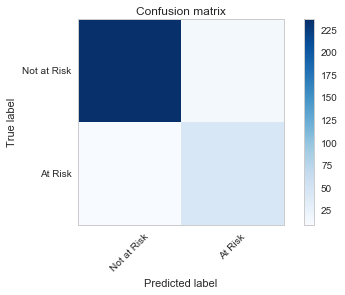

In [102]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=30), get_cm = True)

Avg Feature Importance: [ 0.38966864  0.11553461  0.18332308  0.15874296  0.15273071]
Accuracy: 0.9031372549019607
Precision: 0.719495865035611
Recall: 0.6779999999999999
f1: 0.6960554157458492
ROC AUC: 0.8125546875


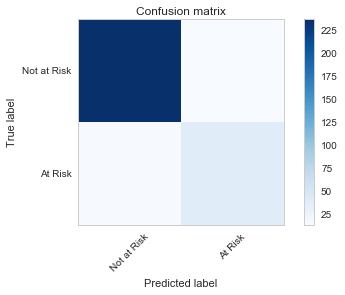

In [103]:
pol_modeling.get_single_model(model=DecisionTreeClassifier(), get_cm = True)